# Import libraries


In [765]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, fbeta_score, make_scorer, ConfusionMatrixDisplay
from sklearn import decomposition, tree
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# Read data


In [766]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 1. Data exploration


In [767]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [768]:
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 1.1 Check for missing values


In [769]:
df.isna().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## 1.2 Handle missing values: assign missing values to the mean value according to each label


In [770]:
mean_bmi = df.groupby("stroke")["bmi"].agg(pd.Series.mean)
mean_bmi

stroke
0    28.823064
1    30.471292
Name: bmi, dtype: float64

In [771]:
df.loc[(df.stroke == 0) & (df.bmi.isna()), "bmi"] = mean_bmi[0]
df.loc[(df.stroke == 1) & (df.bmi.isna()), "bmi"] = mean_bmi[1]

In [772]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# 2. Data visualization


## 2.1 Plot the probability density function (PDF) of continuous numerical features (avg_glucose_level, age, bmi) according to stroke


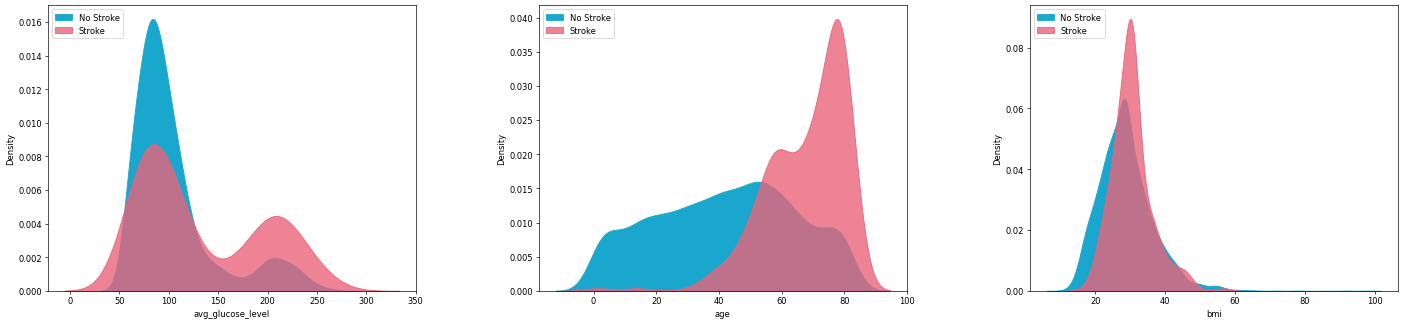

In [773]:
fig = plt.figure(figsize=(50, 15), dpi=60)
gs = GridSpec(ncols=28, nrows=12, left=0.05, right=0.5, wspace=1, hspace=0.1)

ax1 = fig.add_subplot(gs[1:6, 0:8])
ax2 = fig.add_subplot(gs[1:6, 10:18])
ax3 = fig.add_subplot(gs[1:6, 20:])

# Define colors
stroke_color = "#E96479"
not_stroke_color = "#19A7CE"

# Average Glucose Level
sns.kdeplot(x="avg_glucose_level", data=df[df.stroke == 0], ax=ax1,
            shade=True, color=not_stroke_color, alpha=1, label="No Stroke")
sns.kdeplot(x="avg_glucose_level", data=df[df.stroke == 1], ax=ax1,
            shade=True, color=stroke_color, alpha=0.8, label="Stroke")
ax1.legend(loc="upper left")

# Age
sns.kdeplot(x="age", data=df[df.stroke == 0], ax=ax2, shade=True,
            color=not_stroke_color, alpha=1, label="No Stroke")
sns.kdeplot(x="age", data=df[df.stroke == 1], ax=ax2,
            shade=True, color=stroke_color, alpha=0.8, label="Stroke")
ax2.legend(loc="upper left")

# BMI
sns.kdeplot(x="bmi", data=df[df.stroke == 0], ax=ax3, shade=True,
            color=not_stroke_color, alpha=1, label="No Stroke")
sns.kdeplot(x="bmi", data=df[df.stroke == 1], ax=ax3,
            shade=True, color=stroke_color, alpha=0.8, label="Stroke")
ax3.legend(loc="upper left")

## => 

# 3. Data preprocessing


## 3.1 Explore the categorical features


In [774]:
# explore categorical features (also known as nominal feature, are variables that contain label values rather than numeric values and often limited to a fixed set)

for col in ["gender", "work_type", "Residence_type", "smoking_status"]:
    print(f"{col}: {df[col].value_counts().to_dict()}")
    print("")

gender: {'Female': 2994, 'Male': 2115, 'Other': 1}

work_type: {'Private': 2925, 'Self-employed': 819, 'children': 687, 'Govt_job': 657, 'Never_worked': 22}

Residence_type: {'Urban': 2596, 'Rural': 2514}

smoking_status: {'never smoked': 1892, 'Unknown': 1544, 'formerly smoked': 885, 'smokes': 789}



## 3.2 Data Binning


In [775]:
df["bmi_bin"] = pd.qcut(df["bmi"], q=4)
df["avg_glucose_level_bin"] = pd.cut(df["avg_glucose_level"], bins=[0, 100, 125, 150, 200, 300])


In [776]:
df["bmi_bin"].value_counts(sort=True)

(10.299000000000001, 23.8]    1294
(23.8, 28.4]                  1282
(28.4, 32.8]                  1271
(32.8, 97.6]                  1263
Name: bmi_bin, dtype: int64

In [777]:
df["avg_glucose_level_bin"].value_counts(sort=True)


(0, 100]      3131
(100, 125]     979
(200, 300]     434
(150, 200]     296
(125, 150]     270
Name: avg_glucose_level_bin, dtype: int64

In [778]:
df["avg_glucose_level_bin"] = pd.cut(
    df["avg_glucose_level"],
    bins=[0, 100, 125, 150, 200, 300],
    labels=["Low", "Normal", "High", "Very High", "Extremely High"],
)


In [779]:
df["bmi_bin"] = pd.qcut(
    df["bmi"],
    q=4,
    labels=["Underweight", "Normal", "Overweight", "Obese"],
)


In [780]:
df


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_bin,avg_glucose_level_bin
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Obese,Extremely High
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.471292,never smoked,1,Overweight,Extremely High
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Overweight,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Obese,Very High
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Normal,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.823064,never smoked,0,Overweight,Low
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0,Obese,High
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0,Overweight,Low
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0,Normal,Very High


## 3.2 Remove outliers


In [781]:
df[df.gender == "Other"]


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_bin,avg_glucose_level_bin
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0,Underweight,High


In [782]:
df = df[df.gender != "Other"]


In [783]:
df = df[df.age > 0.5]

In [784]:
X = df.drop(["id", "avg_glucose_level", "bmi", "stroke"], axis=1)
y = df["stroke"]

In [785]:
X.shape


(5089, 10)

## 3.3 Split the data into training set and test set (with stratification)


In [786]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)


In [787]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4071, 10), (1018, 10), (4071,), (1018,))

## 3.4 Create an instance of column transformer to encode the categorical features

### One-hot encoding: for categorical data

### Ordinal encoding: for ordinal data


In [788]:
# create column transformer
ct = make_column_transformer(
    (OneHotEncoder(), ["gender"]),
    (OneHotEncoder(), ["ever_married"]),
    (OneHotEncoder(), ["work_type"]),
    (OneHotEncoder(), ["Residence_type"]),
    (
        OrdinalEncoder(
            categories=[["never smoked", "Unknown", "formerly smoked", "smokes"]]),
        ["smoking_status"],
    ),
    (
        OrdinalEncoder(
            categories=[["Low", "Normal", "High", "Very High", "Extremely High"]]),
        ["avg_glucose_level_bin"],
    ),
    (
        OrdinalEncoder(
            categories=[["Underweight", "Normal", "Overweight", "Obese"]]),
        ["bmi_bin"],
    ),
    remainder="passthrough",
)


## 3.5 Fit transform the column transformer to the training set and transform the test set


In [789]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [790]:
X_train.shape, y_train.shape

((4071, 17), (4071,))

In [791]:
transformed_cols = ct.get_feature_names_out()
transformed_cols


array(['onehotencoder-1__gender_Female', 'onehotencoder-1__gender_Male',
       'onehotencoder-2__ever_married_No',
       'onehotencoder-2__ever_married_Yes',
       'onehotencoder-3__work_type_Govt_job',
       'onehotencoder-3__work_type_Never_worked',
       'onehotencoder-3__work_type_Private',
       'onehotencoder-3__work_type_Self-employed',
       'onehotencoder-3__work_type_children',
       'onehotencoder-4__Residence_type_Rural',
       'onehotencoder-4__Residence_type_Urban',
       'ordinalencoder-1__smoking_status',
       'ordinalencoder-2__avg_glucose_level_bin',
       'ordinalencoder-3__bmi_bin', 'remainder__age',
       'remainder__hypertension', 'remainder__heart_disease'],
      dtype=object)

## 3.6 Data scaling


In [792]:
X_train


array([[ 0.,  1.,  0., ..., 74.,  1.,  1.],
       [ 1.,  0.,  0., ..., 51.,  0.,  0.],
       [ 1.,  0.,  1., ..., 26.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ..., 69.,  0.,  0.],
       [ 1.,  0.,  1., ..., 37.,  0.,  0.],
       [ 1.,  0.,  0., ..., 74.,  0.,  0.]])

In [793]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [794]:
X_train

array([[0.        , 1.        , 0.        , ..., 0.90176817, 1.        ,
        1.        ],
       [1.        , 0.        , 0.        , ..., 0.61935167, 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.31237721, 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.84037328, 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.44744597, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.90176817, 0.        ,
        0.        ]])

# 4. Model training


## Implement helper functions

In [795]:
def display_metrics(y_test, y_pred):
  data = {
    'Recall': [recall_score(y_pred=y_pred, y_true=y_test, pos_label=0), recall_score(y_pred=y_pred, y_true=y_test, pos_label=1)],
    'Precision': [precision_score(y_pred=y_pred, y_true=y_test, pos_label=0), precision_score(y_pred=y_pred, y_true=y_test, pos_label=1)],
    'F1 Score': [f1_score(y_pred=y_pred, y_true=y_test, pos_label=0), f1_score(y_pred=y_pred, y_true=y_test, pos_label=1)],
    'F10 Score': [fbeta_score(y_pred=y_pred, y_true=y_test, beta=10, pos_label=0), fbeta_score(y_pred=y_pred, y_true=y_test, beta=10, pos_label=1)]
  }

  df = pd.DataFrame(data).set_index([pd.Index(['Class 0', 'Class 1'])])
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print()
  print(df)

In [796]:
def plot_learning_curve(svc_model, dt_model, scoring=make_scorer(fbeta_score, beta=10)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Learning curve for SVM model
    train_sizes, train_scores, test_scores = learning_curve(
        svc_model, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 20))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    axes[0].plot(train_sizes, train_scores_mean, label='Training score')
    axes[0].plot(train_sizes, test_scores_mean, label='Cross-validation score')
    axes[0].set_xlabel('Training set size')
    axes[0].set_ylabel('F beta score')
    axes[0].set_title('Learning curve for SVM')
    axes[0].legend()

    # Learning curve for Decision Tree model
    train_sizes, train_scores, test_scores = learning_curve(
        dt_model, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 20))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    axes[1].plot(train_sizes, train_scores_mean, label='Training score')
    axes[1].plot(train_sizes, test_scores_mean, label='Cross-validation score')
    axes[1].set_xlabel('Training set size')
    axes[1].set_ylabel('F beta score')
    axes[1].set_title('Learning curve for Decision Tree')
    axes[1].legend()

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

In [797]:
def plotConFusionMatrix(y_test, y_pred):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")


## 4.1 Train model with no optimization


### 4.1.1 Train SVM model


In [798]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)


In [799]:
display_metrics(y_test, y_pred_svc)

Accuracy: 0.9508840864440079

         Recall  Precision  F1 Score  F10 Score
Class 0     1.0   0.950884  0.974824   0.999489
Class 1     0.0   0.000000  0.000000   0.000000


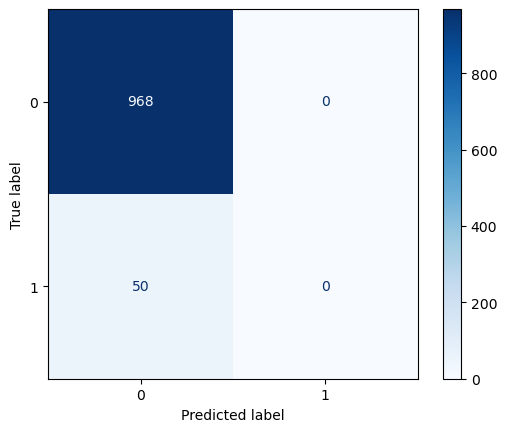

In [800]:
plotConFusionMatrix(y_test, y_pred_svc)

<div style="text-align: center;"> 
  <img src="https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg" alt="Confusion Matrix">
</div>

<h4>TP: the number of patients who have stroke and the model predicts correctly that they have stroke </h4>
<h4>TN: the number of patients who do not have stroke and the model predicts correctly that they do not have stroke</h4>
<h4>FP: the number of patients who do not have stroke but the model predicts incorrectly that they have stroke</h4>
<h4>FN: the number of patients who have stroke but the model predicts incorrectly that they do not have stroke</h4>
<hr>

<h4>

In this problem, we are going to minimize the number of FN (False Negative)
<span style="color: #E06469;">
because it is more dangerous to predict that a patient does not have stroke while he/she actually has stroke.
</span>
</h4>

#### Therefore the recall is more important than accuracy in this case.

<div style="font-size:30px;">

$$Recall = \frac{TP}{TP + FN}$$

</div>

#### On the other hand, we are also interested in the F-measure with more attention put on recall while precision is also considered, such as when false negatives are more important to minimize, but false positives are still important.

<h3 style="color: #E06469;">

Another metric which can be applicable to this problem is the Fbeta-score.

</h3>

#### The Fbeta-score measure is an abstraction of the F-measure where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coefficient called beta.

<div style="font-size:30px;">

$$F_\beta = (1+\beta^2) \times \frac{Precision \times Recall}{\beta^2 \times Precision + Recall}$$

</div>


### 4.1.2 Train decision tree model


In [801]:
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [802]:
display_metrics(y_test, y_pred_dt)

Accuracy: 0.8958742632612967

           Recall  Precision  F1 Score  F10 Score
Class 0  0.938017   0.951782  0.944849   0.938151
Class 1  0.080000   0.062500  0.070175   0.079779


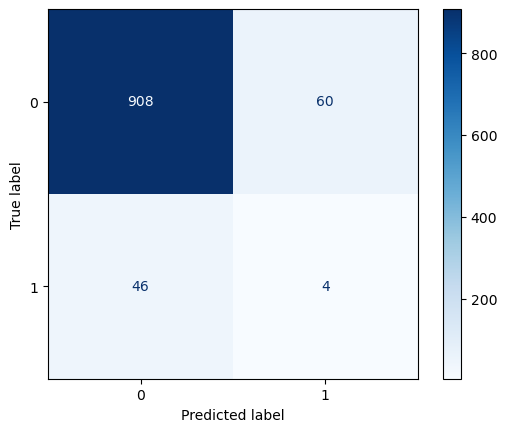

In [803]:
plotConFusionMatrix(y_test, y_pred_dt)

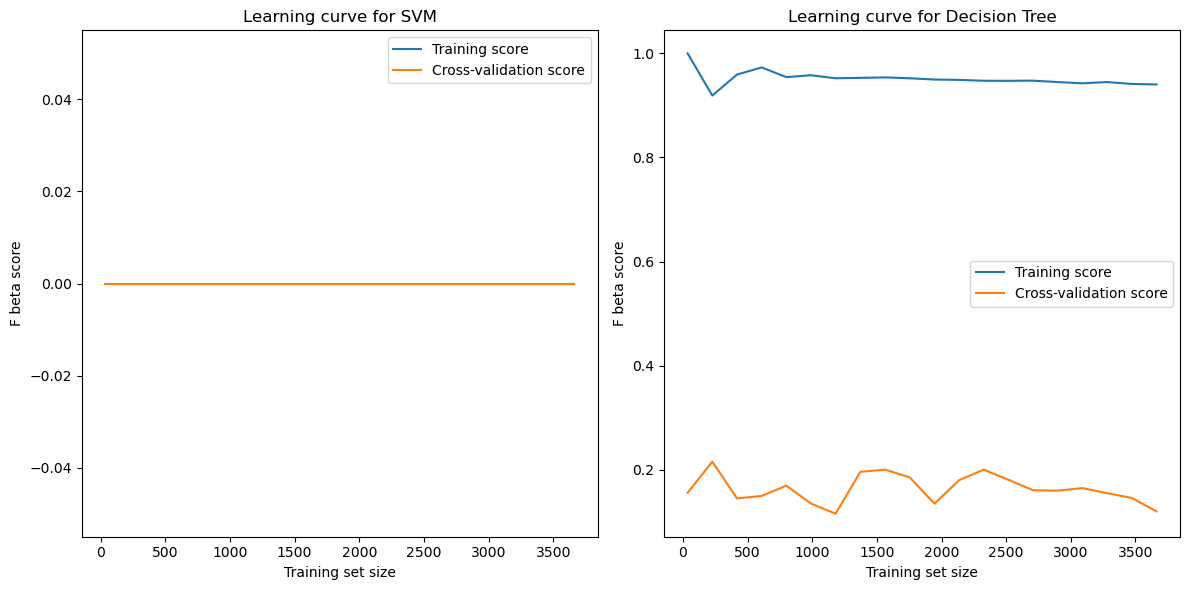

In [804]:
plot_learning_curve(svc_model, dt_model)

## 4.2 Train model with resampling


<Axes: ylabel='stroke'>

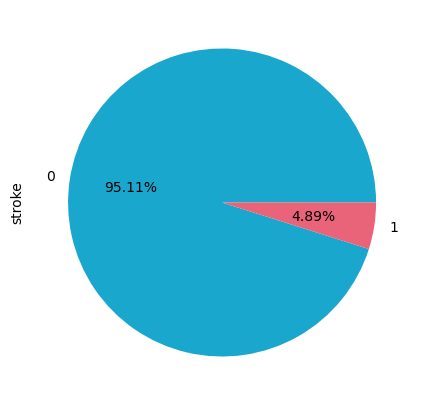

In [805]:
colors = {0: "#19A7CE", 1: "#E96479"}
y_train.value_counts().plot.pie(autopct='%.2f%%', figsize=(5, 5), colors=[colors.get(i) for i in y_train.value_counts().index])

### It can be seen that the data is not balanced, therefore the model will be biased towards the majority class. Although the accuracy is high, the model is not good because the recall score is low (many stroke patients are predicted as non-stroke patients), which is very dangerous in the medical field.

### To solve this problem, we will use SMOTEENN (Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours) to balance the data.


In [806]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

<Axes: ylabel='stroke'>

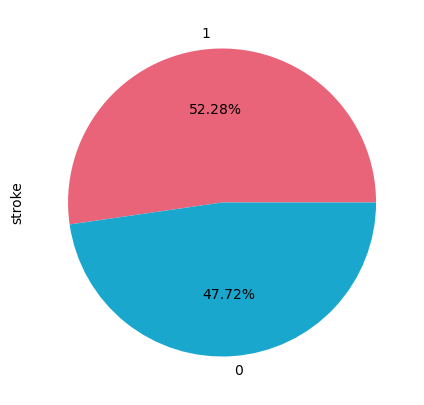

In [807]:
y_train.value_counts().plot.pie(autopct='%.2f%%', figsize=(5, 5), colors=[colors.get(i) for i in y_train.value_counts().index])

### 4.2.1 Train SVM model with Sampling

In [808]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)


In [809]:
display_metrics(y_test, y_pred_svc)

Accuracy: 0.7730844793713163

           Recall  Precision  F1 Score  F10 Score
Class 0  0.784091   0.971831  0.867925   0.785594
Class 1  0.560000   0.118143  0.195122   0.540004


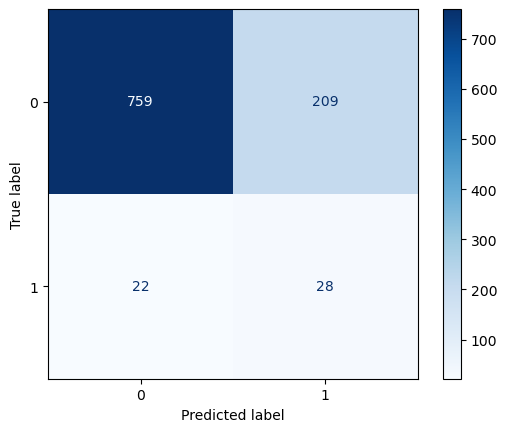

In [810]:
plotConFusionMatrix(y_test, y_pred_svc)

### 4.2.2 Train Decision Tree model with SMOTE


In [811]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [812]:
display_metrics(y_test, y_pred_dt)

Accuracy: 0.8595284872298625

           Recall  Precision  F1 Score  F10 Score
Class 0  0.892562   0.956811  0.923570   0.893156
Class 1  0.220000   0.095652  0.133333   0.217204


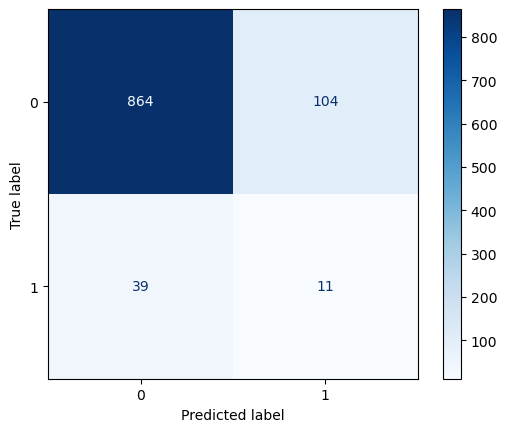

In [813]:
plotConFusionMatrix(y_test, y_pred_dt)

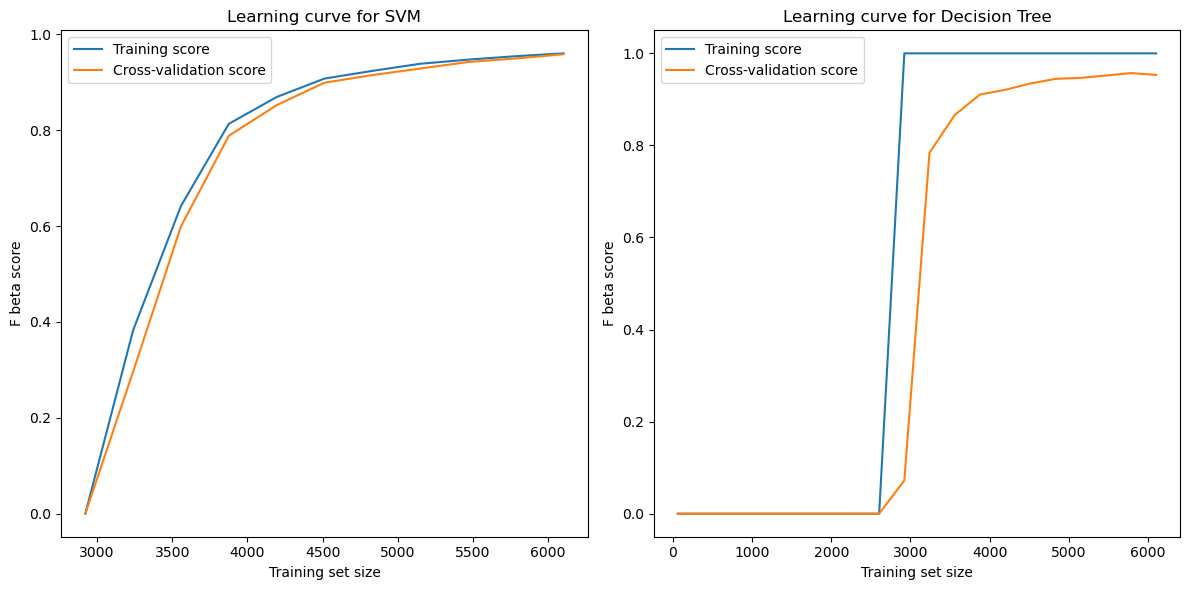

In [814]:
plot_learning_curve(svc_model, dt_model)

## 4.3 Train model with feature selection (to reduce the number of dimensions)


In [815]:
# change numpy array to dataframe
X_train = pd.DataFrame(X_train)

<Axes: >

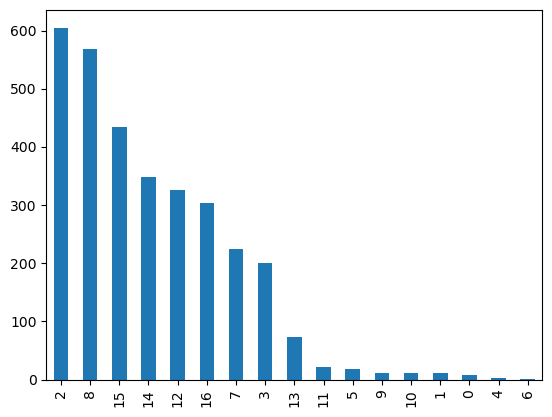

In [816]:
# The higher the chi-square value, the more important the feature is
chi_score = chi2(X_train, y_train)
chi_values = pd.Series(chi_score[0], index=X_train.columns)
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()

<Axes: >

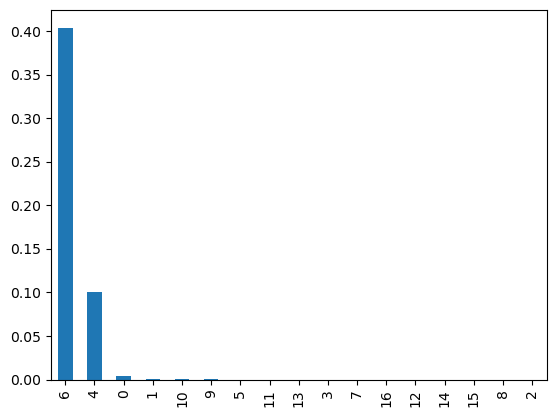

In [817]:
# The higher the p-value, the less important the feature is
p_values = pd.Series(chi_score[1], index=X_train.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()


In [818]:
# select the 8 most important features
k_best = SelectKBest(chi2, k=6)
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)


### 4.3.1 Training SVM model with feature selection, but no hyperparameter tuning


In [819]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

In [820]:
display_metrics(y_test, y_pred_svc)

Accuracy: 0.7131630648330058

           Recall  Precision  F1 Score  F10 Score
Class 0  0.708678   0.985632  0.824519   0.710655
Class 1  0.800000   0.124224  0.215054   0.759113


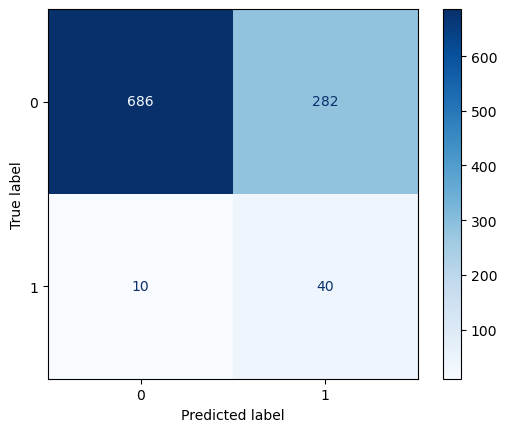

In [821]:
plotConFusionMatrix(y_test, y_pred_svc)


### 4.3.2 Training Decision Tree model with feature selection, but no hyperparameter tuning


In [822]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [823]:
display_metrics(y_test, y_pred_dt)

Accuracy: 0.9056974459724951

          Recall  Precision  F1 Score  F10 Score
Class 0  0.94938   0.951346  0.950362   0.949400
Class 1  0.06000   0.057692  0.058824   0.059976


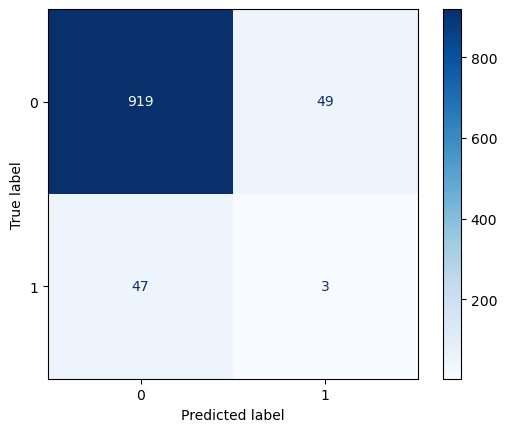

In [824]:
plotConFusionMatrix(y_test, y_pred_dt)


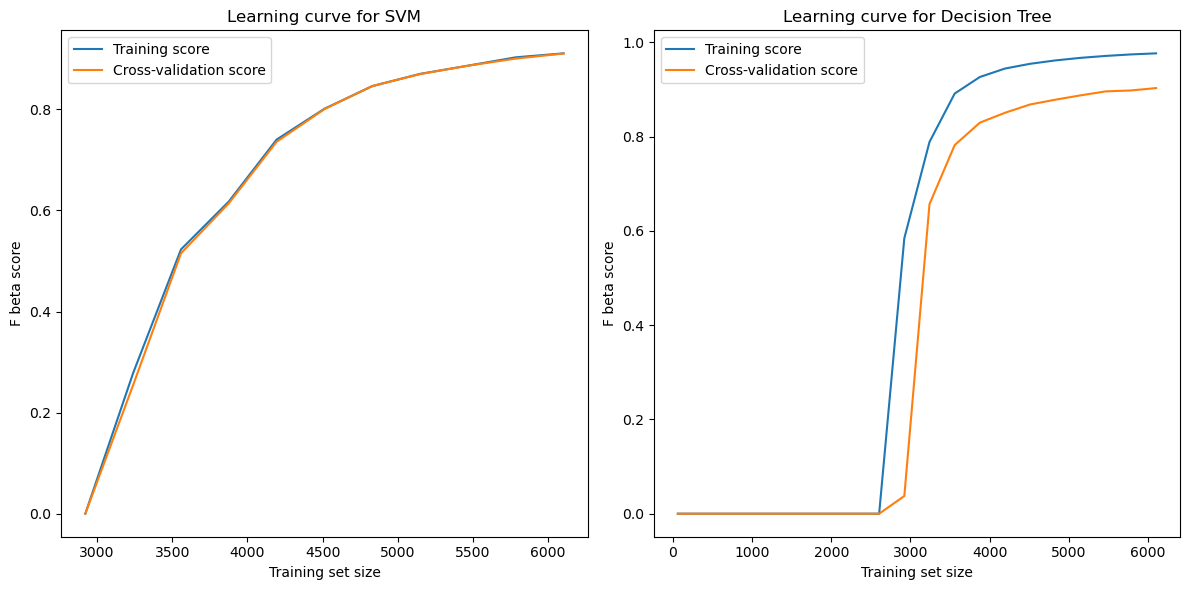

In [825]:
plot_learning_curve(svc_model, dt_model)

## 4.5 Train model with hyperparameter tuning using GridSearchCV


### 4.5.1 Train Decision tree model with oversampled data, feature selection, and hyperparameter tuning


In [826]:
# Creating a pca object
pca = decomposition.PCA()

# Creating a DecisionTreeClassifier
dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('pca', pca), ('dec_tree', dec_tree)])

# Creating lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = np.arange(2, 6)
min_samples_split_values = np.arange(2, 6)

# Creating a dictionary of all the parameter options
parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split_values)

scoring = make_scorer(fbeta_score, beta=10)

# Creating a grid search object with the scoring metric
clf_GS = GridSearchCV(pipe, parameters, scoring=scoring, cv=5)

# Fitting the grid search
clf_GS.fit(X_train, y_train)

# Viewing The Best Parameters
print('Best max_depth:', clf_GS.best_estimator_.get_params()
      ['dec_tree__max_depth'])
print('Best criterion:', clf_GS.best_estimator_.get_params()
      ['dec_tree__criterion'])
print('Best min_samples_split:', clf_GS.best_estimator_.get_params()
      ['dec_tree__min_samples_split'])


Best max_depth: 3
Best criterion: entropy
Best min_samples_split: 2


In [827]:
dt_model = DecisionTreeClassifier(
    criterion=clf_GS.best_estimator_.get_params()['dec_tree__criterion'],
    max_depth=clf_GS.best_estimator_.get_params()['dec_tree__max_depth'], 
    min_samples_split=clf_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
dt_model = dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [828]:
display_metrics(y_test, y_pred_dt)

Accuracy: 0.7514734774066798

         Recall  Precision  F1 Score  F10 Score
Class 0    0.75   0.985075  0.851613   0.751776
Class 1    0.78   0.138790  0.235650   0.745881


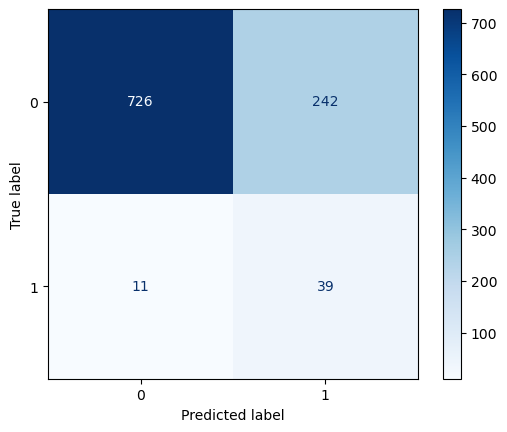

In [829]:
# confusion matrix
plotConFusionMatrix(y_test, y_pred_dt)


### Visualize the Decision Tree model


In [831]:
text_representation = tree.export_text(dt_model)
print(text_representation)


|--- feature_3 <= 0.59
|   |--- feature_3 <= 0.46
|   |   |--- feature_3 <= 0.34
|   |   |   |--- class: 0
|   |   |--- feature_3 >  0.34
|   |   |   |--- class: 0
|   |--- feature_3 >  0.46
|   |   |--- feature_2 <= 0.00
|   |   |   |--- class: 0
|   |   |--- feature_2 >  0.00
|   |   |   |--- class: 0
|--- feature_3 >  0.59
|   |--- feature_2 <= 0.00
|   |   |--- feature_3 <= 0.82
|   |   |   |--- class: 0
|   |   |--- feature_3 >  0.82
|   |   |   |--- class: 1
|   |--- feature_2 >  0.00
|   |   |--- feature_2 <= 0.25
|   |   |   |--- class: 1
|   |   |--- feature_2 >  0.25
|   |   |   |--- class: 1



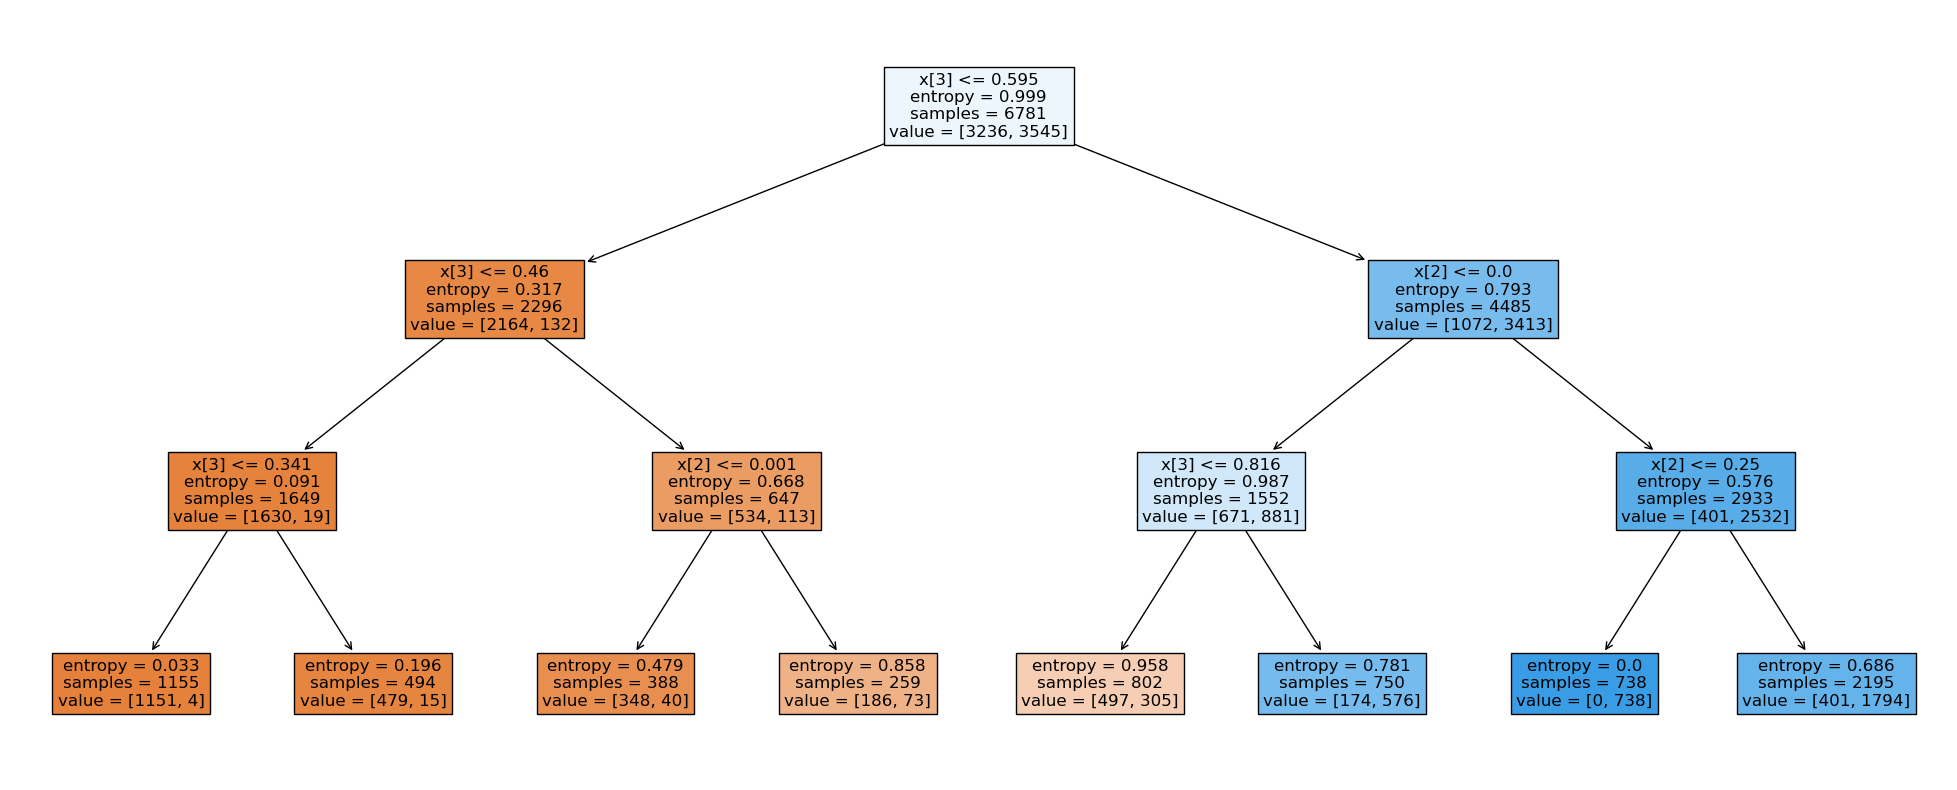

In [832]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25, 10))
plot_tree(dt_model, filled=True, fontsize=12)
plt.show()


### 4.5.2 Training SVM model with optimal hyperparameters


In [833]:
# defining parameter range
param_grid = {'C': [1, 10],
              'gamma': [1, 0.1, 0.01]
              }

# defining the scoring metric
scoring = make_scorer(fbeta_score, beta=10)

# creating the GridSearchCV object with the custom scoring metric
grid = GridSearchCV(SVC(), param_grid, refit=True,
                    verbose=3, scoring=scoring, cv=5)

# fitting the model for grid search
grid.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......................C=1, gamma=1;, score=0.912 total time=   0.6s
[CV 2/5] END ......................C=1, gamma=1;, score=0.921 total time=   0.5s
[CV 3/5] END ......................C=1, gamma=1;, score=0.895 total time=   0.5s
[CV 4/5] END ......................C=1, gamma=1;, score=0.905 total time=   0.5s
[CV 5/5] END ......................C=1, gamma=1;, score=0.914 total time=   0.5s
[CV 1/5] END ....................C=1, gamma=0.1;, score=0.906 total time=   0.6s
[CV 2/5] END ....................C=1, gamma=0.1;, score=0.909 total time=   0.6s
[CV 3/5] END ....................C=1, gamma=0.1;, score=0.893 total time=   0.6s
[CV 4/5] END ....................C=1, gamma=0.1;, score=0.902 total time=   0.6s
[CV 5/5] END ....................C=1, gamma=0.1;, score=0.911 total time=   0.6s
[CV 1/5] END ...................C=1, gamma=0.01;, score=0.925 total time=   0.9s
[CV 2/5] END ...................C=1, gamma=0.01;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(fbeta_score, beta=10), verbose=3)

In [834]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 1, 'gamma': 0.01}
SVC(C=1, gamma=0.01)


In [835]:
svc_model = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

In [836]:
display_metrics(y_test, y_pred_svc)

Accuracy: 0.6709233791748527

           Recall  Precision  F1 Score  F10 Score
Class 0  0.663223   0.986175  0.793082   0.665381
Class 1  0.820000   0.111717  0.196643   0.771567


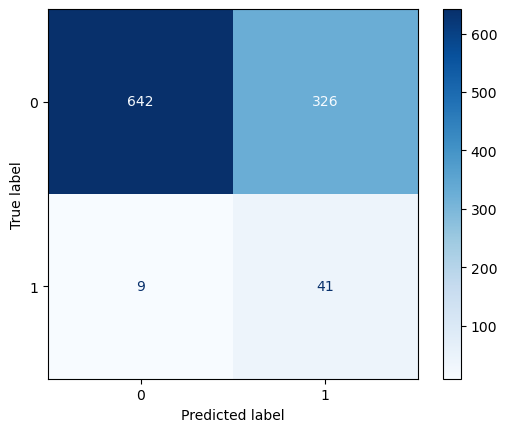

In [837]:
plotConFusionMatrix(y_test, y_pred_svc)

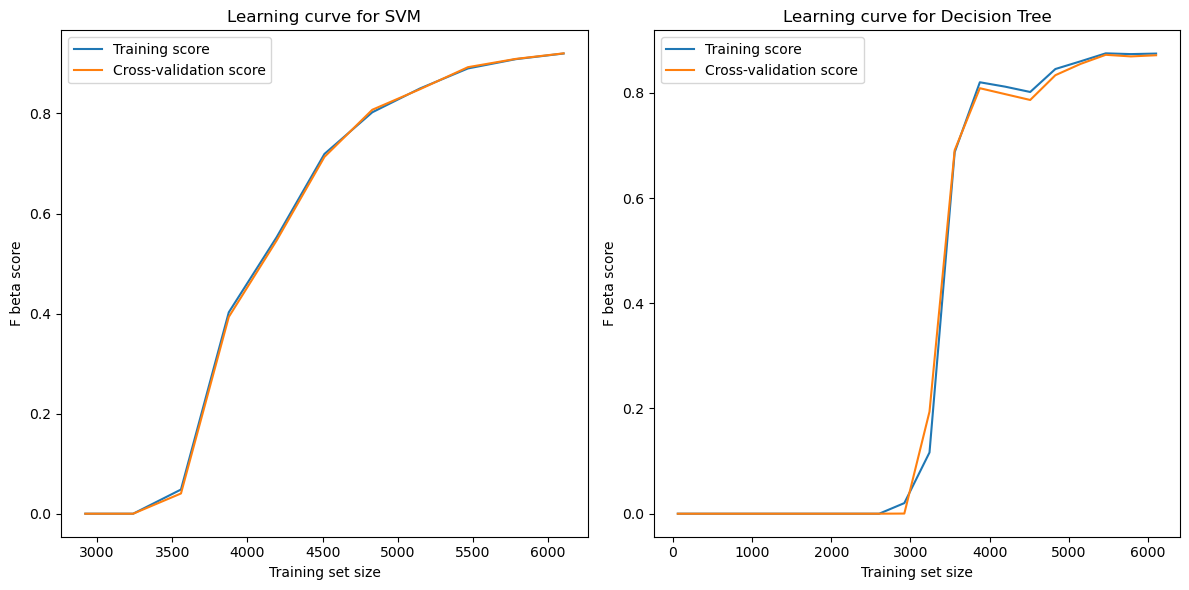

In [838]:
plot_learning_curve(svc_model, dt_model)

# 5. Model evaluation


## 5.1 Visualize the F_beta-score with different beta values

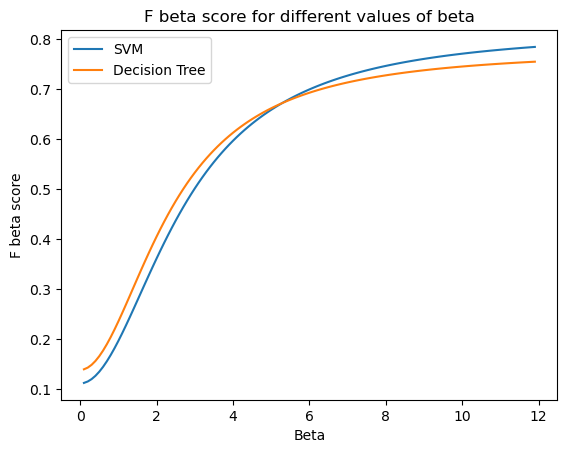

In [839]:
beta = np.arange(0.1, 12, 0.1)
f_beta_svc = []
f_beta_dt = []
for i in beta:
    f_beta_svc.append(fbeta_score(y_test, y_pred_svc, beta=i))
    f_beta_dt.append(fbeta_score(y_test, y_pred_dt, beta=i))

plt.plot(beta, f_beta_svc, label='SVM')
plt.plot(beta, f_beta_dt, label='Decision Tree')
plt.xlabel('Beta')
plt.ylabel('F beta score')
plt.title('F beta score for different values of beta')
plt.legend()
plt.show()


#### => It can be seen from the graph that when the weight of recall compared to precision is significant (beta > threshold), the SVC model performs better than the Decision Tree model. However, when beta < theshold, the Decision Tree model performs better than the SVC model regarding the F_beta-score.

## 5.2 Display the classification report for the positive class between the Decision Tree model and the SVC model

<!DOCTYPE html>
<html>
<head>
	<title></title> 
	<style>
		table {
			border:1px groove #000000;
			border-collapse:collapse;
			padding:5px;
		}
		table th {
			border:1px groove #000000;
			padding:5px;
			background: #d1d1d1;
			color: #000000;
		}
		table td {
			border:1px groove #000000;
			text-align:center;
			padding:5px;
			background: #ffffff;
			color: #313030;
		}
	</style>
</head>
<body>
    <table>
    	<thead>
    		<tr>
    			<th>Model</th>
					<th>Metrics</th>
    			<th>No optimization</th>
    			<th>Over-sampling</th>
    			<th>Feature selection</th>
    			<th>Hyper-parameter tuning</th>
    		</tr>
    	</thead>
    	<tbody>
    		<tr>
    			<td rowspan="3">&nbsp;SVM</td>
					<td>Recall</td>
    			<td>&nbsp;0</td>
    			<td>&nbsp;0.580</td>
    			<td>&nbsp;0.694</td>
    			<td>0.920&nbsp;</td>
    		</tr>
				<tr>
					<td>Precision</td>
    			<td>&nbsp;0</td>
    			<td>&nbsp;0.113</td>
    			<td>&nbsp;0.113</td>
    			<td>0.720&nbsp;</td>
    		</tr>
				<tr>
					<td>F_10 score</td>
    			<td>&nbsp;0</td>
    			<td>&nbsp;0.560</td>
    			<td>&nbsp;0.660</td>
    			<td>0.823&nbsp;</td>
    		</tr>
    		<tr>
    			<td rowspan="3">&nbsp;Decision Tree</td>
					<td>Recall</td>
    			<td>&nbsp;0.113</td>
    			<td>&nbsp;0.145</td>
    			<td>&nbsp;0.194</td>
    			<td>0.774</td>
    		</tr>
				<tr>
					<td>Precision</td>
    			<td>&nbsp;0.101</td>
    			<td>&nbsp;0.095</td>
    			<td>&nbsp;0.222</td>
    			<td>0.134</td>
    		</tr>
				<tr>
					<td>F_10 score</td>
    			<td>&nbsp;0.011</td>
    			<td>&nbsp;0.144</td>
    			<td>&nbsp;0.194</td>
    			<td>0.740</td>
    		</tr>
    	</tbody>
    </table>
</body>
</html>
